<a href="https://colab.research.google.com/github/jvataidee/PesquisaOperacional/blob/master/cadeias_de_markov.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cadeias de Markov com Python
---

O presente modelo é um estudo didático referente a disciplina de Cadeias de Markov do curso do MBA de Pesquisa Operacional e Tomada de Decisão da BsBR.

Como caso de estudo iremos realizar a criação de um modelo para identifica sequência de eventos mais prováveis de acontecer no treinamento de um modelo de Deep Learning, tendo o foco final colocar esse modelo em Produção.



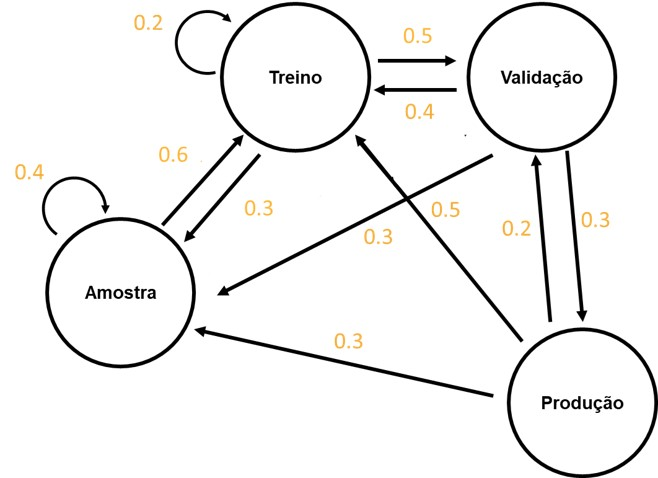

In [2]:
import numpy as np
import random as rm
import pandas as pd
import matplotlib.pyplot as plt

Os dados probabilísticos aqui foram analisando em conjunto com cientistas de dados, avaliando de forma subjetiva como e qual a sequência específicas de eventos nos treinamentos dos seus modelos de deep learning.

In [3]:
estados_desenvolvimento = ["Amostra", "Treino", "Validação","Produção"]
sequencias = [["Amostra -> Amostra", "Amostra -> Treino", "Amostra -> Validação", "Amostra -> Produção"],
              ["Treino -> Amostra", "Treino -> Treino", "Treino -> Validação", "Treino -> Produção"],
              ["Validação -> Amostra", "Validação -> Treino", "Validação -> Validação", "Validação -> Produção"],
              ["Produção -> Amostra", "Produção -> Treino", "Produção -> Validação", "Produção -> Produção"]]

prob_sequencia = [[0.4, 0.6, 0.0, 0.0],
                  [0.3, 0.2, 0.5, 0.0],
                  [0.3, 0.4, 0.0, 0.3],
                  [0.3, 0.5, 0.2, 0.0]]

In [4]:
for idex, value in enumerate(sequencias):
    print(value[0], "Prob:", prob_sequencia[idex][0])
    print(value[1], "Prob:", prob_sequencia[idex][1])
    print(value[2], "Prob:", prob_sequencia[idex][2])
    print(value[3], "Prob:", prob_sequencia[idex][3])

    print("Probabilidade Total", prob_sequencia[idex][0]+prob_sequencia[idex][1]+prob_sequencia[idex][2]+prob_sequencia[idex][3], "\n")

Amostra -> Amostra Prob: 0.4
Amostra -> Treino Prob: 0.6
Amostra -> Validação Prob: 0.0
Amostra -> Produção Prob: 0.0
Probabilidade Total 1.0 

Treino -> Amostra Prob: 0.3
Treino -> Treino Prob: 0.2
Treino -> Validação Prob: 0.5
Treino -> Produção Prob: 0.0
Probabilidade Total 1.0 

Validação -> Amostra Prob: 0.3
Validação -> Treino Prob: 0.4
Validação -> Validação Prob: 0.0
Validação -> Produção Prob: 0.3
Probabilidade Total 1.0 

Produção -> Amostra Prob: 0.3
Produção -> Treino Prob: 0.5
Produção -> Validação Prob: 0.2
Produção -> Produção Prob: 0.0
Probabilidade Total 1.0 



## Crindo script

In [5]:
#Criando classe de Markov
class MarkovChain(object):
    def __init__(self, transition_matrix, states):
        self.transition_matrix = np.atleast_2d(transition_matrix)
        self.states = states
        self.index_dict = {self.states[index]: index for index in range(len(self.states))}
        self.states_dict = {index: self.states[index] for index in range(len(self.states))}

    #Definir função do estado futuro
    def next_state(self,current_state):
        return np.random.choice( self.states,
            p = self.transition_matrix[self.index_dict[current_state], :])

    #Gerar estados d problema
    def generate_states(self, current_state, no = 10):
        future_states = []

        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state

        return future_states

    def generate_especific_states(self, current_state, stop_state):
        future_states = []
        i = 1
        while current_state != stop_state:
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
            i += 1

        return future_states

    def generate_simulation(self, current_state, stop_state, sm = 10):
        n_estados = []
        resultado_sim = []

        for i in range(sm):
            resultado = self.generate_especific_states(current_state, stop_state)
            n_estados.append(len(resultado)+1)
            resultado_sim.append(resultado)

        return n_estados, resultado_sim


    def generate_risc(self, current_state, stop_state, nn = 3, nm = 20, sm = 10):
        erro = 0
        nerro = 0

        resultado = self.generate_simulation(current_state, stop_state, sm)

        for i in range(len(resultado[1])):
            if len(resultado[1][i]) < nn:
                erro += 1
            if len(resultado[1][i]) > nm:
                erro += 1
            if len(resultado[1][i]) < nm and len(resultado[1][i]) > nn:
                nerro += 1
        
        p_erro = (erro/sm)*100
        p_nerro = (nerro/sm)*100

        return resultado, erro, nerro, p_erro, p_nerro


In [6]:
atividades_modelo = MarkovChain(transition_matrix = prob_sequencia,
                                states = estados_desenvolvimento)

## Proximo estado

In [7]:
#Definindo estados atual e futuro
estato_atual = 'Amostra'
estato_futuro = 'Produção'

In [8]:
atividades_modelo.next_state(current_state = estato_atual)

'Treino'

In [9]:
simulacoes = 1000000

resultado = []
for i in range(simulacoes):
    resultado.append(atividades_modelo.next_state(current_state = estato_atual))

In [10]:
resultado_count = pd.DataFrame(resultado).value_counts()
resultado_count

Treino     599864
Amostra    400136
dtype: int64

## Gerando estados futuros

## Simulando
Na simulação, vamos considerar que cada evento ocorre em uma semana, com isso, realizando diversas simulações dos eventos e dos estados podemos etimar a quantidade de semanas que demandaria para realizar um treinamento de um modelo.

In [11]:
numero_semanas  = 10
resultado = atividades_modelo.generate_states(current_state = estato_atual, no = numero_semanas)
resultado

['Amostra',
 'Amostra',
 'Treino',
 'Validação',
 'Produção',
 'Amostra',
 'Treino',
 'Validação',
 'Treino',
 'Validação']

In [12]:
resultado_count = pd.DataFrame(resultado).value_counts()
resultado_count

Amostra      3
Treino       3
Validação    3
Produção     1
dtype: int64

## Parando em um estado específico

In [13]:
resultado = atividades_modelo.generate_especific_states(current_state = estato_atual,
                                                        stop_state = estato_futuro )
resultado

['Amostra', 'Treino', 'Validação', 'Produção']

In [14]:
simulacoes = 200

resultado = atividades_modelo.generate_simulation(current_state = estato_atual,
                                                  stop_state = estato_futuro,
                                                  sm = simulacoes )

In [15]:
len(resultado[1][1])

8

In [16]:
resultado_df  = pd.DataFrame()
resultado_df["Semanas"] = resultado[0]
resultado_df["Resultado"] = resultado[1]
resultado_df["Simulacao"] = 0

simulacao = []
for i in range(len(resultado_df["Resultado"])):
    simulacao.append(i+1)

resultado_df["Simulacao"] = simulacao

In [17]:
resultado_df.head()

,Semanas,Resultado,Simulacao
0,14,"[Amostra, Amostra, Treino, Validação, Treino, ...",1
1,9,"[Amostra, Amostra, Treino, Amostra, Treino, Tr...",2
2,9,"[Treino, Amostra, Treino, Validação, Amostra, ...",3
3,4,"[Treino, Validação, Produção]",4
4,17,"[Treino, Amostra, Amostra, Amostra, Treino, Am...",5


In [18]:
resultado_df["Média Semanas"] = np.mean(resultado_df["Semanas"])
resultado_df["Média Semanas"][0] 

17.77

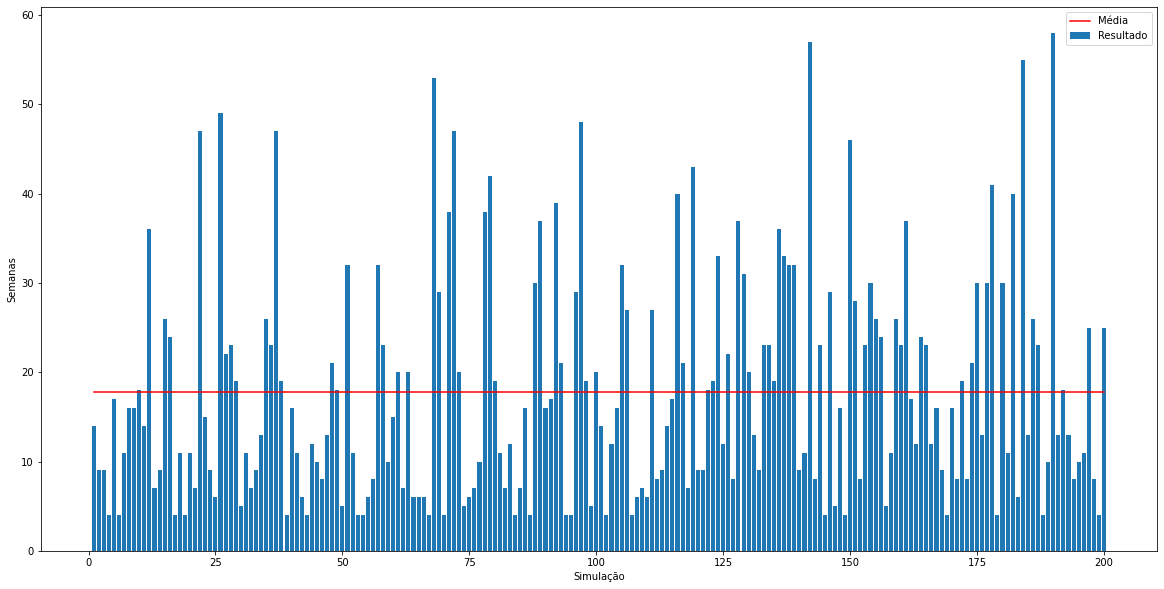

In [19]:
plt.figure(figsize=(20,10)) 
plt.bar(resultado_df["Simulacao"],resultado_df["Semanas"], label = "Resultado")
plt.plot(resultado_df["Simulacao"],resultado_df["Média Semanas"], label = "Média", color = 'r')
plt.xlabel("Simulação")
plt.ylabel("Semanas")
plt.legend()
plt.show();

## Avaliando se dá certo ou errado o projeto

In [34]:
simulacoes = 10000
semana_maxima = 20
semana_min = 3

resultado = atividades_modelo.generate_risc(current_state = estato_atual,
                                            stop_state = estato_futuro,
                                            nn = semana_min, nm = semana_maxima,
                                            sm = simulacoes )

In [35]:
print(f"Dá Errado {round(resultado[3],2)} % \nDá Certo {round(resultado[4],2)} %")

Dá Errado 28.21 % 
Dá Certo 60.29 %
